The definition of "best" is going to be zipcodes that have the highest projected increases in values over the next 3 years. 

---------------------------------------------------------------------------------------------------------------------

The top 5 zip-codes are: 

94027 - $2,707,113.10 Projected Increase Home Values

33480 - $2,308,861.29 Projected Increase Home Values

90210 - $2,160,768.42 Projected Increase Home Values

81611 - $1,710,540.68 Projected Increase Home Values

94022 - $1,384,253.88 Projected Increase Home Values

---------------------------------------------------------------------------------------------------------------------

While I initially looked into creating my own SARIMA model with the data, I was not happy with the AIC and models ability to predict the home values in general. I looked into tuning the model until it became too computationally expensive and then opted to go with Facebooks predictive method (prophet) to make the predictions shown above.

---------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import itertools
import numpy as np
import statsmodels.api as sm
from fbprophet import Prophet as proph
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

#Extracting and inspecting data. This is an interesting format, I will have to modify DF to work with ts data properly

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df1 = df.iloc[:, 7:]
df1 = df1.T
df1.columns = df.RegionName
df1['idx'] = df1.index
df1.idx = pd.to_datetime(df1.idx)
df1.set_index('idx', inplace=True)
df1 = df1.loc['2016-01-01':]
df1.head()

# All data before 7th column is not necessary and can be referrenced later on. I took the pertinent data and added a 
# proper datetime index that then replaces the current index so that TS data will be plotted and understood by my
# models going forward. I am getting data from 2016 as we want to target the zip codes with the best growth since 
# 2016.

RegionName,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
idx,,,,,,,,,,,,,,,,,,,,,
2016-01-01,952500.0,277900.0,327300.0,1230700.0,116200.0,149600.0,370700.0,734700.0,156100.0,3731000.0,...,117900.0,212500.0,151000.0,333300.0,117100.0,189500.0,186900.0,108900.0,556400.0,304700.0
2016-02-01,958600.0,280000.0,327000.0,1235400.0,115600.0,150600.0,367600.0,739400.0,157800.0,3776100.0,...,117300.0,215300.0,150600.0,334700.0,111400.0,188700.0,186700.0,109800.0,549000.0,305100.0
2016-03-01,966200.0,282600.0,327200.0,1241300.0,115000.0,151200.0,365800.0,736900.0,159500.0,3793100.0,...,116900.0,215700.0,150100.0,335900.0,108000.0,188600.0,186400.0,110700.0,547700.0,305800.0
2016-04-01,970400.0,285400.0,328500.0,1245700.0,114500.0,151800.0,367200.0,732800.0,161500.0,3766500.0,...,117300.0,218000.0,149300.0,336100.0,105600.0,189400.0,186500.0,111400.0,549600.0,307300.0
2016-05-01,973900.0,288400.0,329800.0,1247000.0,114200.0,153000.0,372200.0,731000.0,164000.0,3720300.0,...,118200.0,222400.0,149300.0,337100.0,104900.0,189600.0,186700.0,111900.0,553100.0,309300.0


In [4]:
growth = {}

for i in df1.columns:
    growth[i] = df1[i][-1] - df1[i][0]
    
# Getting a list of all growth in home values from 2016 till the end of the datas timeframe

In [5]:
gdf = pd.DataFrame.from_dict(growth, orient='index')
gdf = gdf.rename(columns={0: "Increase"})
gdf = gdf.sort_values(by=['Increase'], ascending=False)
gdf.head()

# Converting dictionary of each zipcodes growth into a pd dataframe and then sorting values to get the top zipcodes
# for growth

,Increase
94027,1325500.0
90210,1234000.0
94301,1028400.0
94022,969800.0
94024,825900.0


In [6]:
top15 = []

for i in range(15):
    top15.append(gdf.index[i])
    
# Getting a list of the top 15 zipcodes for growth since 2016

In [7]:
df2 = df.iloc[:, 7:]
df2 = df2.T
df2.columns = df.RegionName
df2['idx'] = df2.index
df2.idx = pd.to_datetime(df2.idx)
df2.set_index('idx', inplace=True)
df2 = df2.loc['2012-01-01':]
df2.head()

# Here I am getting the data for the top zipcodes since 2012 to provide more data points to build model on.
# Also, generally 2012 is the trough of all RE markets, so I am only using data from that
# point on to predict values.

RegionName,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
idx,,,,,,,,,,,,,,,,,,,,,
2012-01-01,737700.0,199600.0,248600.0,928900.0,112400.0,113200.0,306400.0,565300.0,116000.0,2244700.0,...,115000.0,196200.0,151400.0,230600.0,121400.0,174600.0,185300.0,107100.0,513300.0,197600.0
2012-02-01,733700.0,200100.0,251600.0,923900.0,112200.0,112800.0,301300.0,555400.0,115900.0,2261100.0,...,114500.0,195000.0,150000.0,232700.0,121800.0,174700.0,186600.0,107700.0,511700.0,198400.0
2012-03-01,734000.0,200700.0,252800.0,925300.0,112400.0,112600.0,298300.0,549300.0,115800.0,2276900.0,...,114400.0,194700.0,149600.0,240200.0,121500.0,175200.0,187100.0,108900.0,507700.0,199100.0
2012-04-01,740300.0,201800.0,252400.0,938100.0,112800.0,112000.0,295200.0,552400.0,115200.0,2303700.0,...,113500.0,195800.0,149100.0,247800.0,121000.0,175400.0,184700.0,109600.0,503700.0,199500.0
2012-05-01,744600.0,202700.0,252600.0,951900.0,113200.0,111800.0,294700.0,555300.0,114700.0,2339400.0,...,111700.0,196800.0,148900.0,253200.0,119900.0,175200.0,181800.0,109400.0,500800.0,200600.0


In [8]:
topdf = df2.loc[:, top15]
topdf.head()

# using .loc method to get a df of top 15 zipcodes for growth to perform statistical analysis on and predict values

RegionName,94027,90210,94301,94022,94024,94040,11975,81611,98039,33480,11930,11932,94306,95030,95070
idx,,,,,,,,,,,,,,,
2012-01-01,3086600.0,2632200.0,1865700.0,1789400.0,1562700.0,1078800.0,1745900.0,3141700.0,1278900.0,2595600.0,1857900.0,1605100.0,1316800.0,1605900.0,1514200.0
2012-02-01,3097900.0,2663800.0,1897000.0,1813300.0,1581300.0,1097200.0,1756100.0,3102900.0,1280800.0,2643200.0,1852600.0,1594600.0,1338600.0,1625000.0,1529400.0
2012-03-01,3132700.0,2691700.0,1953700.0,1856600.0,1621700.0,1123700.0,1786100.0,3137700.0,1288000.0,2677800.0,1846300.0,1590600.0,1377800.0,1657700.0,1564700.0
2012-04-01,3177000.0,2734000.0,2015400.0,1900600.0,1662200.0,1147100.0,1822800.0,3189600.0,1300600.0,2695200.0,1869900.0,1595700.0,1419700.0,1691400.0,1598000.0
2012-05-01,3242200.0,2790000.0,2074700.0,1943900.0,1696000.0,1169000.0,1881700.0,3207900.0,1313700.0,2708800.0,1893100.0,1589700.0,1459400.0,1722000.0,1621200.0


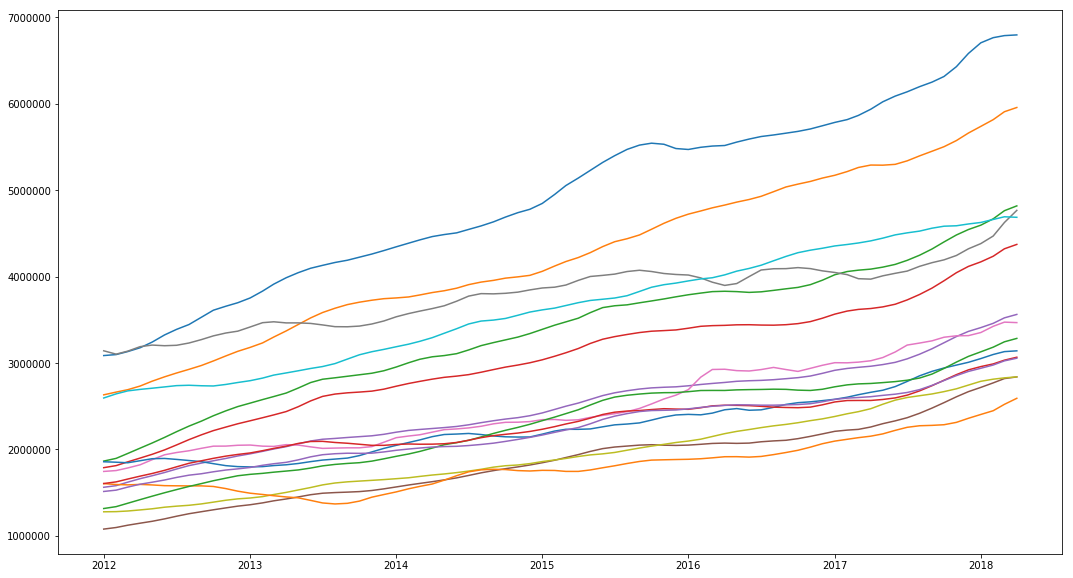

In [12]:
plt.figure(figsize=(18,10))
plt.plot(topdf);

# Taking a look at zipcodes that have the top 15 growth in home values since 2012

In [13]:
def get_aic(df, pdq, pdqs):
    results = []

    for comb in pdq:
        for combs in pdqs:
            mod = sm.tsa.statespace.SARIMAX(df, order=comb, seasonal_order=combs, enforce_stationarity=False, enforce_invertibility=False)
            fitted = mod.fit()
            results.append([comb, combs, fitted.aic])
                
    return results

def get_min_aic(results):
    df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
    min_aic = df.loc[df.aic.idxmin()]
    pdq, pdqs, aic = min_aic[0], min_aic[1], min_aic[2]
    return pdq, pdqs, aic

def get_model(zipcode, pdq, pdqs):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zipcode,
                                order=pdq,
                                seasonal_order=pdqs,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    model = ARIMA_MODEL.fit()
    
    return model

def get_mse(zipcode, model):
    predict = model.get_prediction(start='01-01-2015', dynamic=True, full_results=True)
    pred_conf = predict.conf_int()
    forecasted = predict.predicted_mean
    truth = zipcode['2015':]

    mse = ((forecasted - truth) ** 2).mean()
    
    return mse

def prediction_viz(zipcode, model):
    prediction = model.get_forecast(35)
    pred_conf = prediction.conf_int()

    plt.figure(figsize=(18,8))

    plt.plot(zipcode, label='Observed Values')

    prediction.predicted_mean.plot(label='Forecast')

    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='grey')

    plt.title('{}'.format(zipcode.name))
    plt.ylabel('Home Values')
    plt.xlabel('Dates')
    plt.legend();
    
# Here I am creating functions to automate the process of manually creating the best model for each zip-code and then
# creating a visualization of the data and predicted values.

In [14]:
def assessment(df):
    ivalues = []
    
    p = d = q = range(0, 2)
    pdq1 = list(itertools.product(p, d, q))
    pdqs1 = [(x[0], x[1], x[2], 18) for x in list(itertools.product(p, d, q))]
    
    for i in df.columns:
        ndf = df[i].resample('MS').mean()
        ndf = ndf.fillna(ndf.bfill())
        
        results = get_aic(ndf, pdq1, pdqs1)
        pdq, pdqs, aic = get_min_aic(results)
        model = get_model(ndf, pdq, pdqs)
        mse = get_mse(ndf, model)
        ivalues.append([i, pdq, pdqs, aic, mse])
        prediction_viz(ndf, model)
        
    return ivalues

# Here is all the previous functions combined to create a function that creates the visualiztions and returns 
# important values needed to determine quality of each zip-codes model.

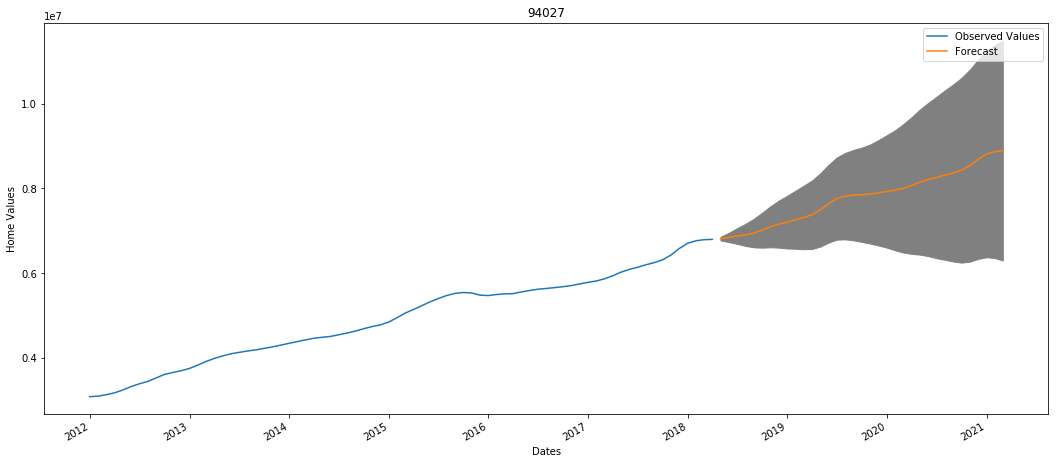

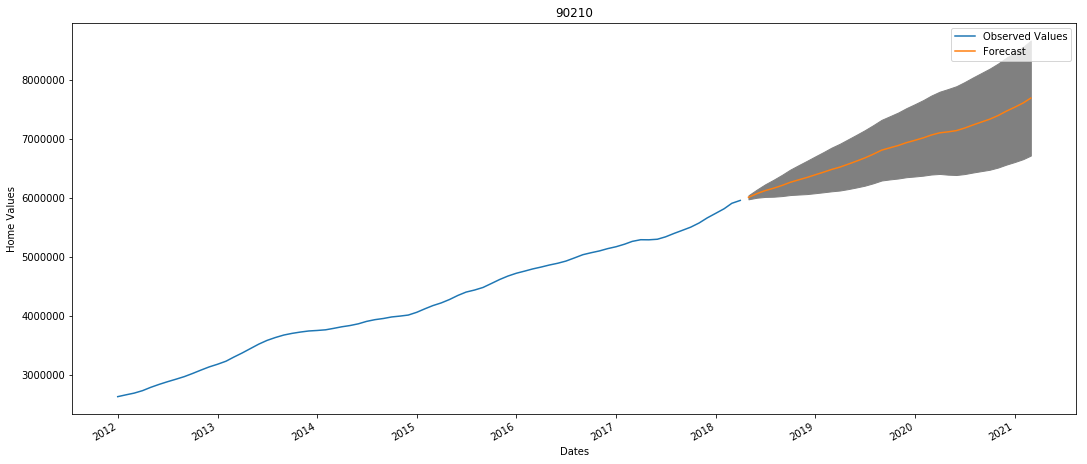

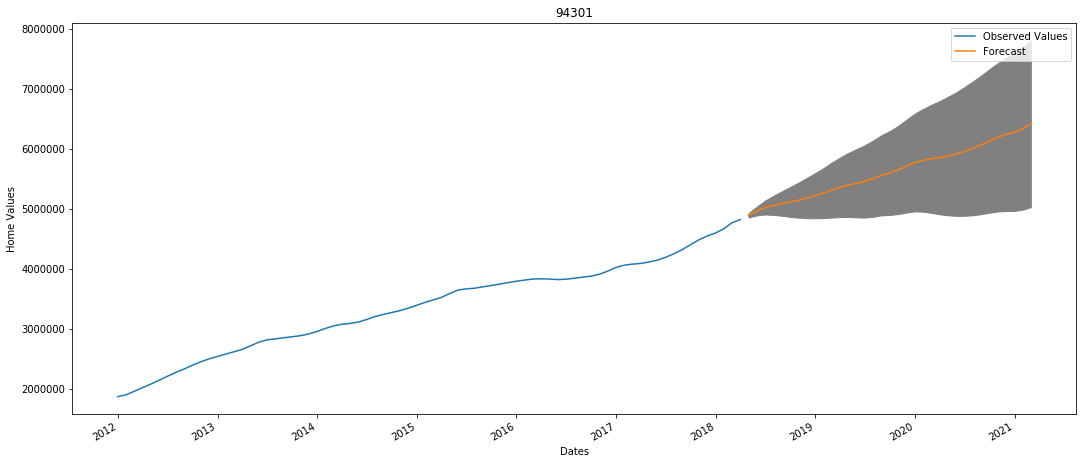

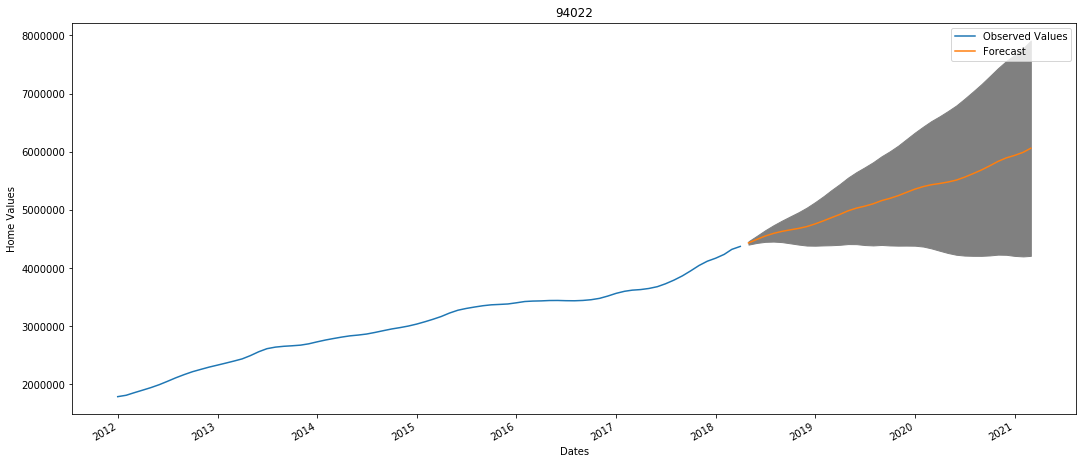

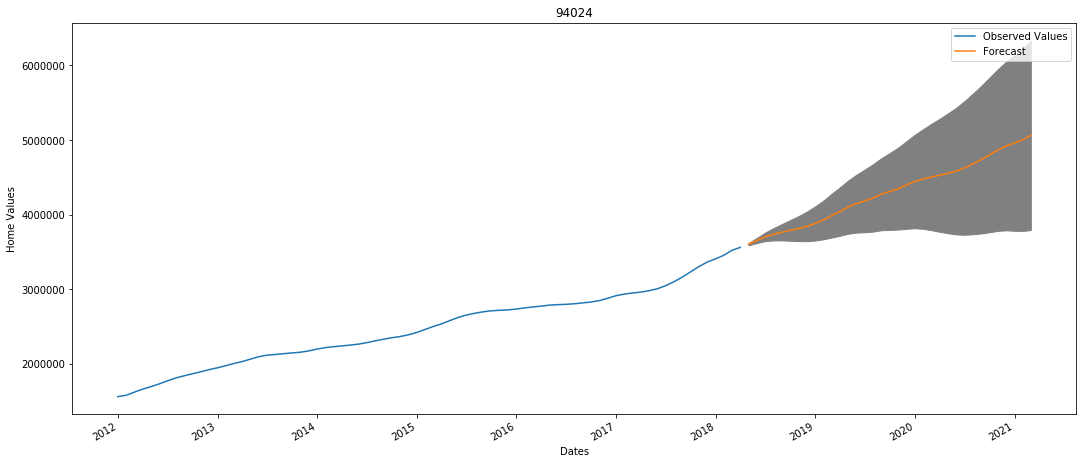

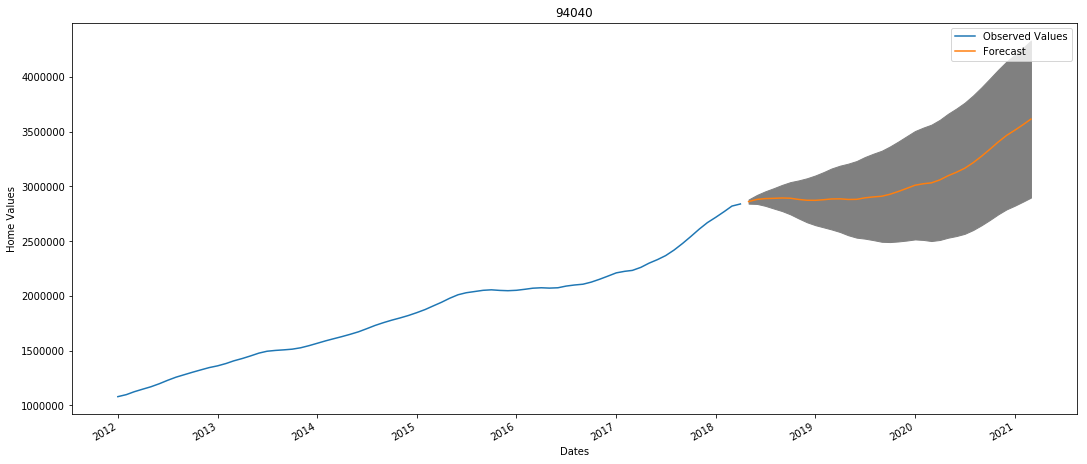

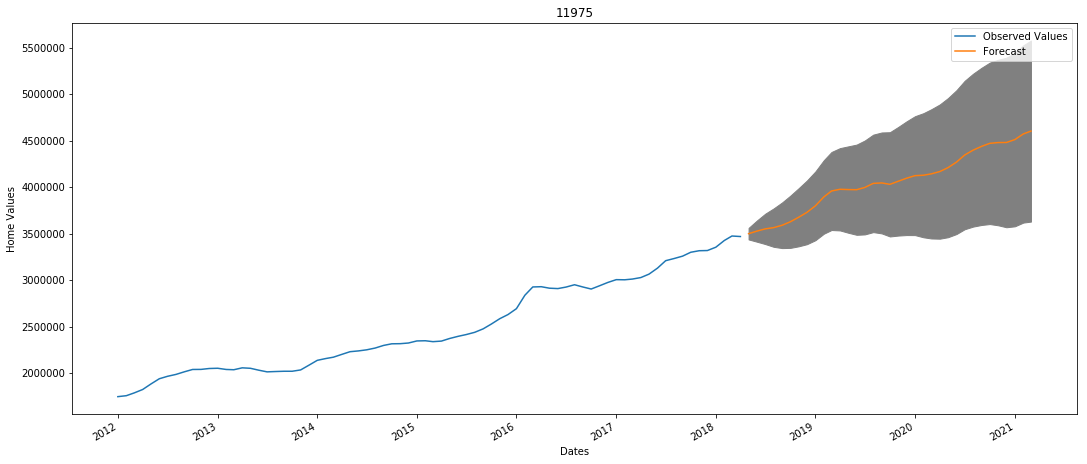

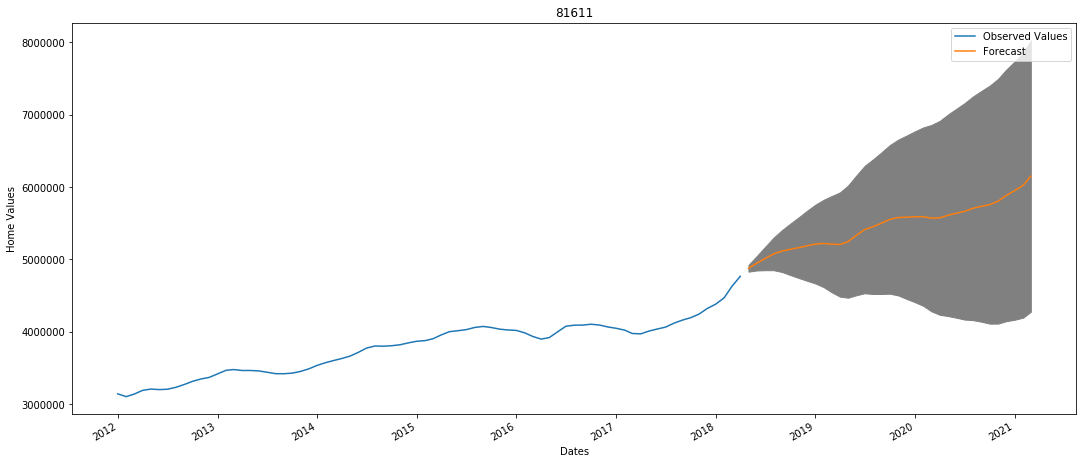

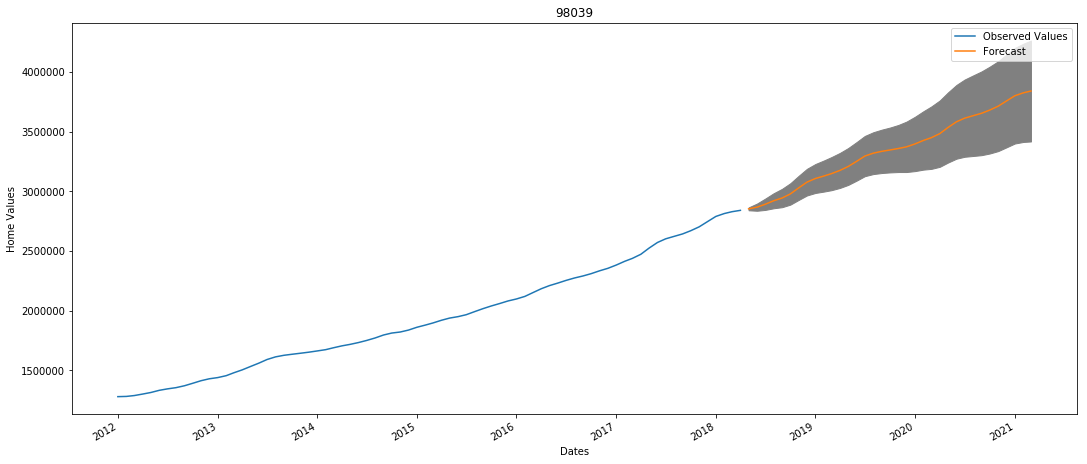

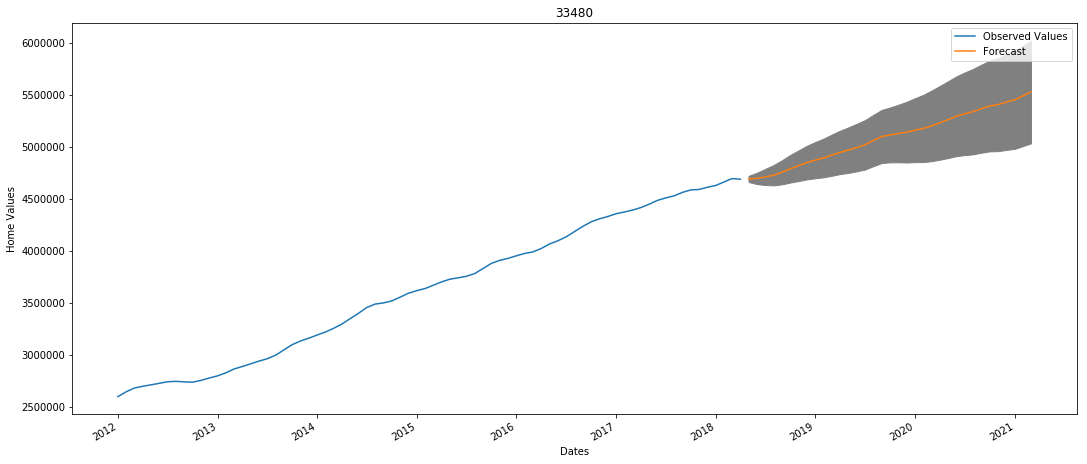

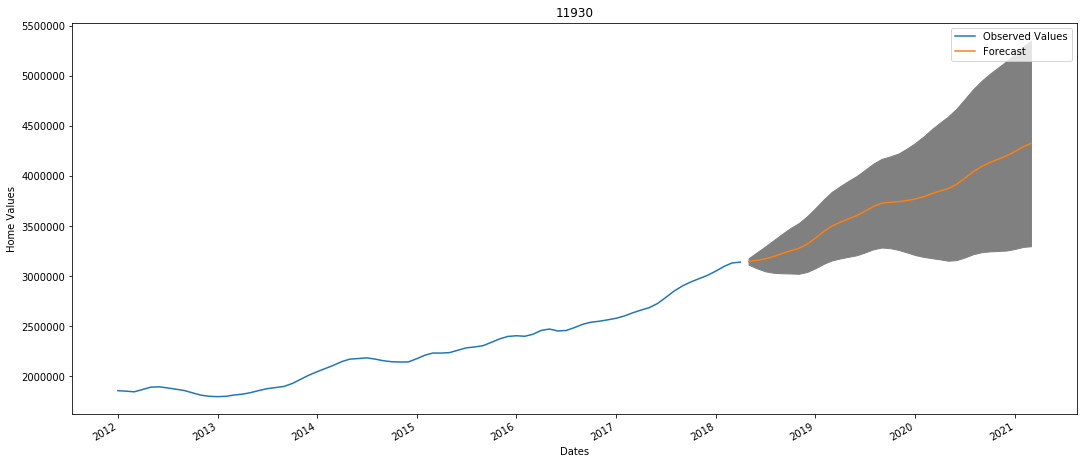

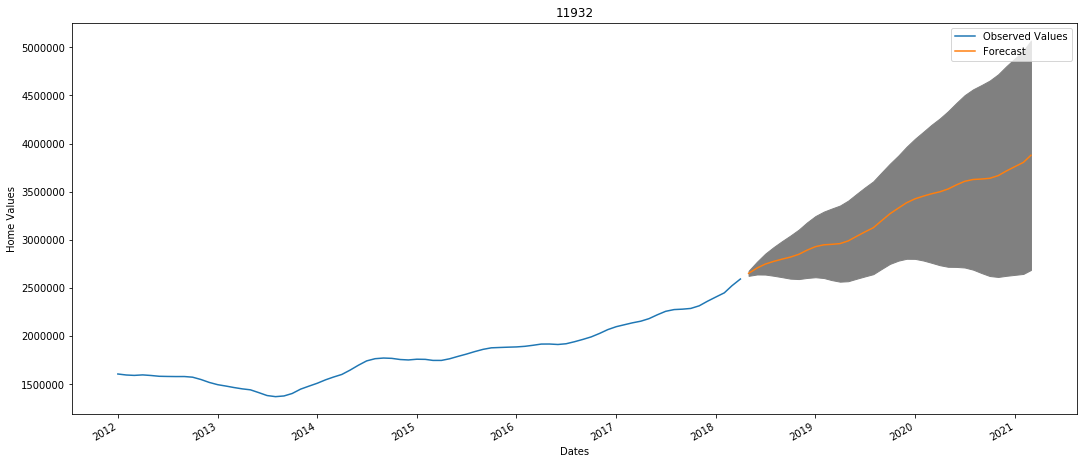

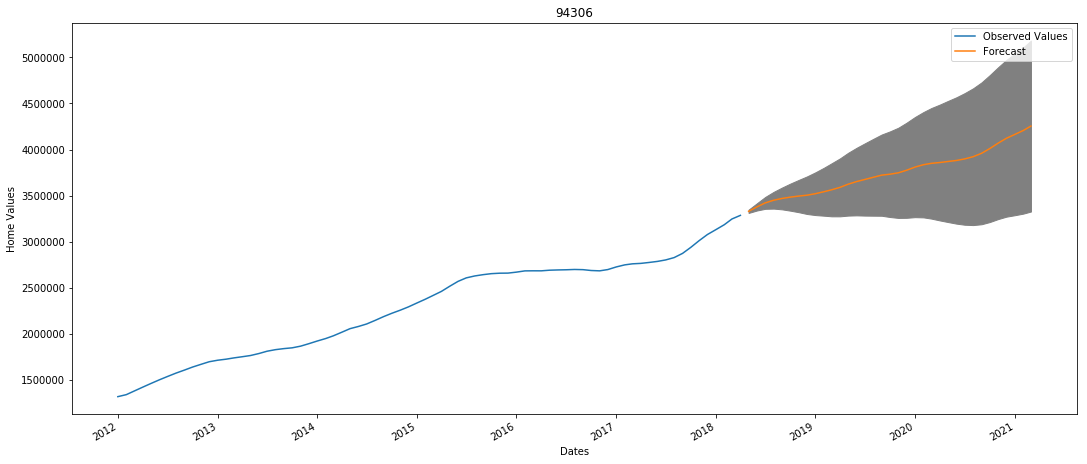

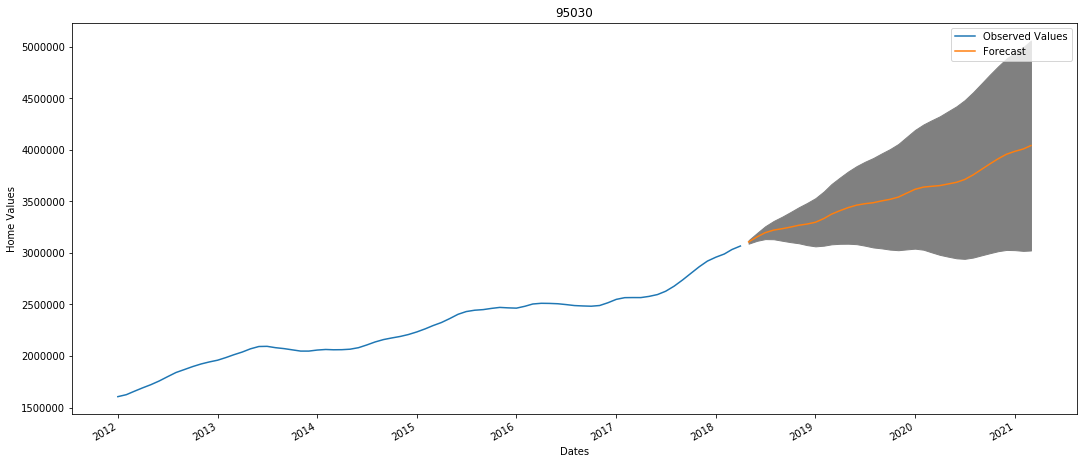

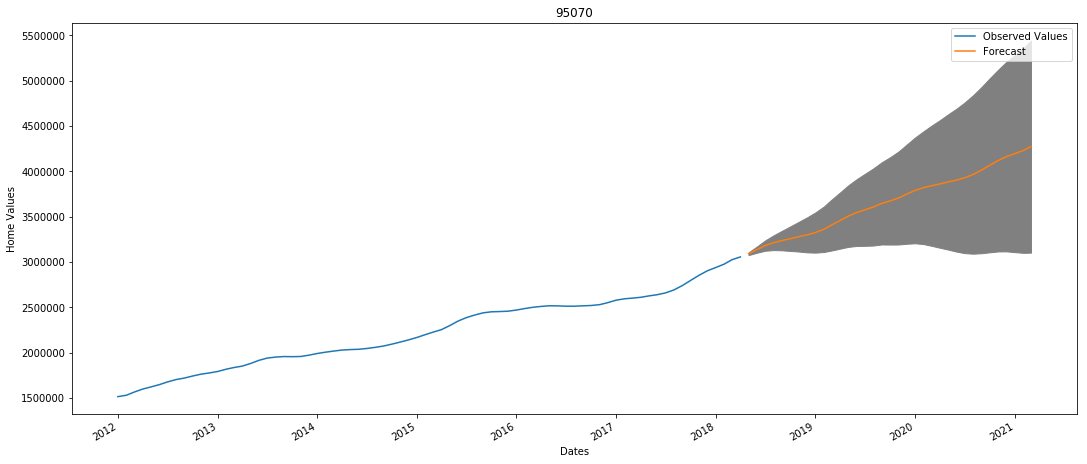

In [15]:
vals = assessment(topdf)

In [16]:
vals

# The following aic is significantly less than that of the other models (around 2500) although I am not completely
# sold on the results of the model. I could try and get different iterations of (p, d, q) and (P, D, Q)s with higher
# values although the computational complexity is going to grow significantly with each value introduced. I am 
# instead opting to use Facebook's prophet method to get the values I will be using to base my zip-code rankings on.

[[94027, (1, 1, 1), (1, 1, 1, 18), 854.6563526372197, 56303587713.065506],
 [90210, (1, 1, 0), (1, 1, 0, 18), 845.0811905900824, 1326541845243.2793],
 [94301, (1, 1, 0), (1, 1, 0, 18), 856.2710395780073, 1207155063694.232],
 [94022, (1, 1, 0), (1, 1, 0, 18), 837.310509657123, 515597596283.7643],
 [94024, (1, 1, 1), (1, 1, 1, 18), 781.9952104919223, 135828530545.2459],
 [94040, (1, 1, 1), (1, 1, 1, 18), 795.1265707086117, 843619690401.7765],
 [11975, (1, 1, 0), (1, 1, 0, 18), 902.8249352851124, 513693191920.7457],
 [81611, (1, 1, 1), (1, 1, 1, 18), 875.3608389226342, 4914756423245.91],
 [98039, (1, 1, 1), (1, 1, 0, 18), 779.4942508398543, 38818999504.1823],
 [33480, (1, 1, 0), (1, 1, 0, 18), 840.0760194047355, 1264679242973.0444],
 [11930, (1, 1, 1), (1, 1, 0, 18), 843.0095279602352, 14686412494.314005],
 [11932, (1, 1, 1), (1, 1, 0, 18), 831.6660182854729, 80164646569.93474],
 [94306, (1, 1, 1), (1, 1, 1, 18), 801.5200537681619, 1018920487696.9788],
 [95030, (1, 1, 1), (1, 1, 1, 18), 7

---------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------

In [17]:
dfx = df.iloc[:, 7:]
dfx = dfx.T
dfx.columns = df.RegionName
dfx['ds'] = dfx.index

# Here I am getting the database set up for the prophet prediction method from facebook

In [25]:
def prophet_prediction(df, topzips):
    dscol = [x for x in df.ds]
    
    values = []
    
    for i in topzips:
        ycol = [x for x in df[i]]
        
        ts = pd.DataFrame()
        ts['ds'] = dscol
        ts['y'] = ycol
        
        Model = proph(interval_width=0.95)
        Model.fit(ts)
        future_dates = Model.make_future_dataframe(periods=36, freq='MS')
        forecast = Model.predict(future_dates)
        diff = round(forecast['yhat'][110] - forecast['yhat'][0], 2)
        values.append((i, diff))
        Model.plot(forecast, uncertainty=True)
        plt.title(i)
        plt.ylabel('Home Value')
        plt.xlabel('Year')
        Model.plot_components(forecast)
        plt.title(i)
        plt.ylabel('Home Value')
        plt.xlabel('Year');
        
    return values 

# Here I am automating the process to get the method to run predictions on all zip codes in the top 15 for home
# value increase.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

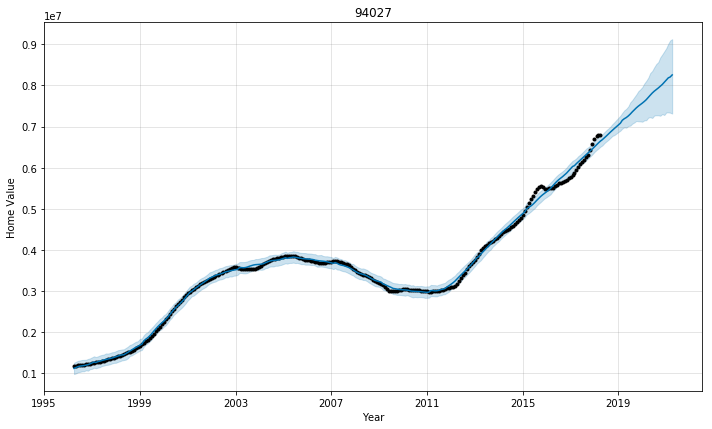

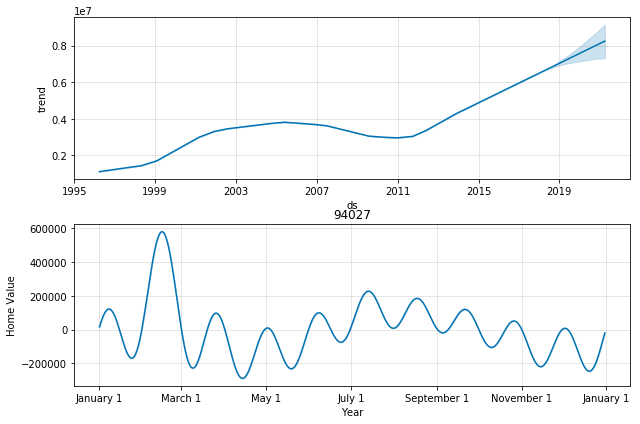

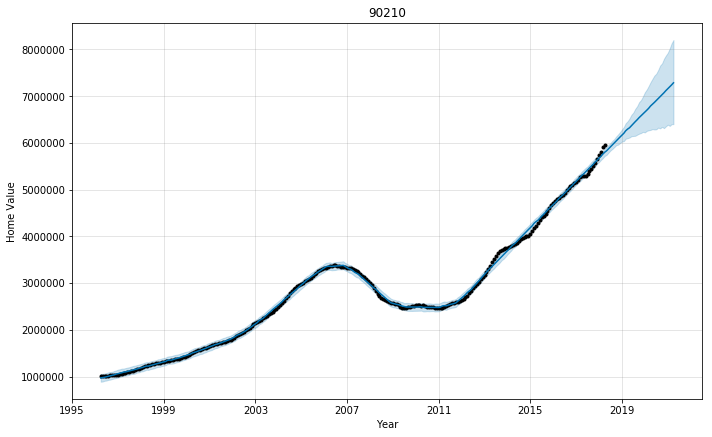

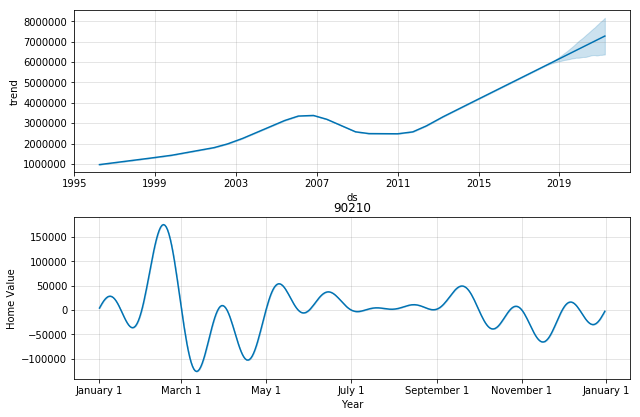

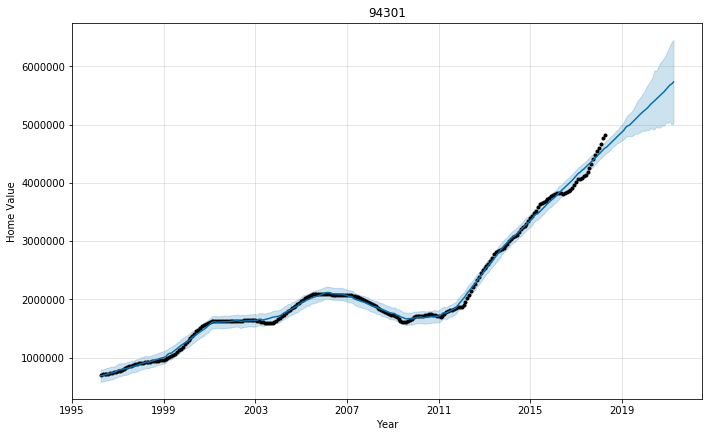

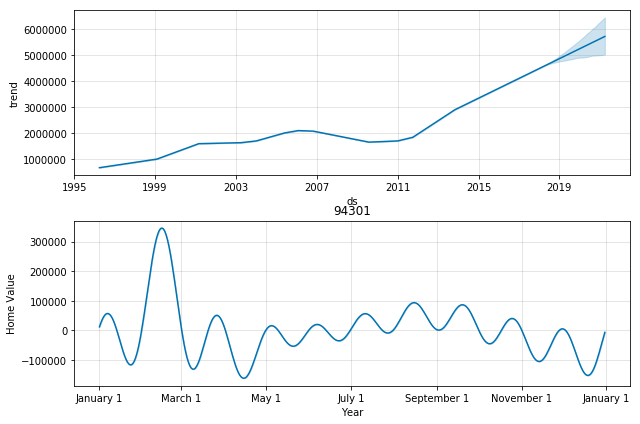

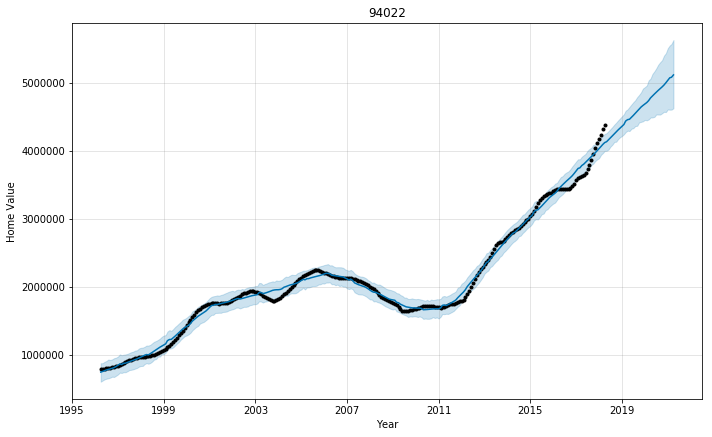

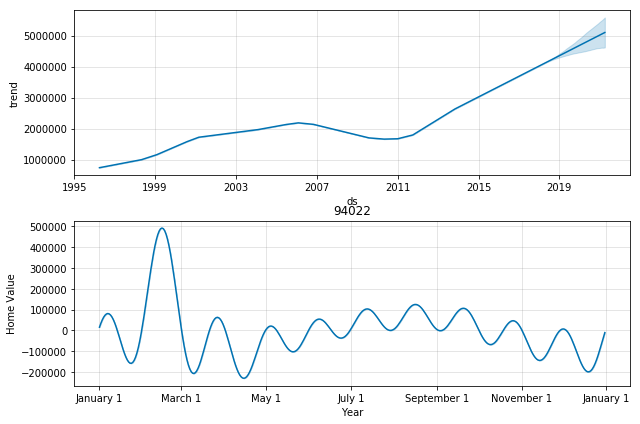

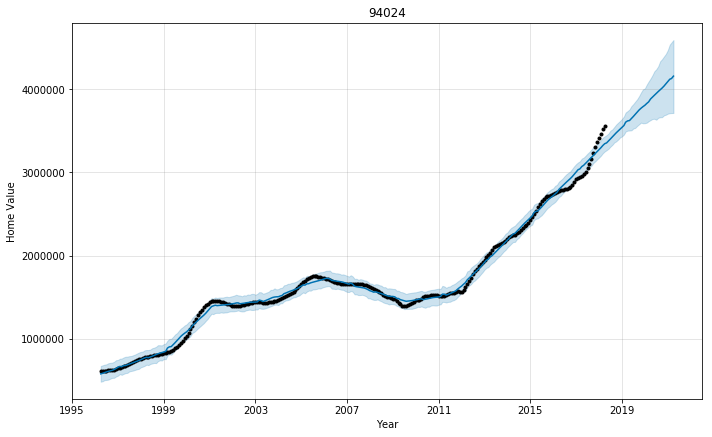

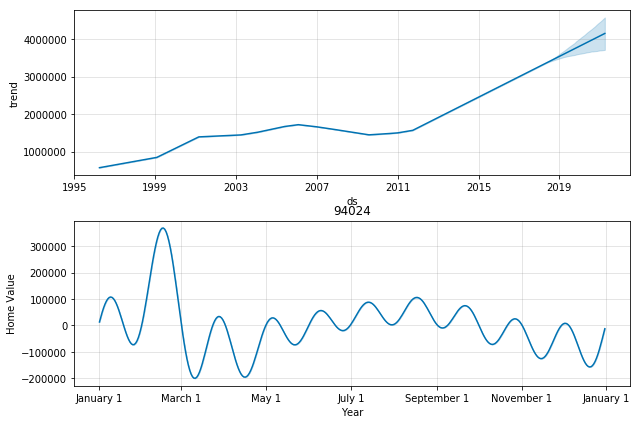

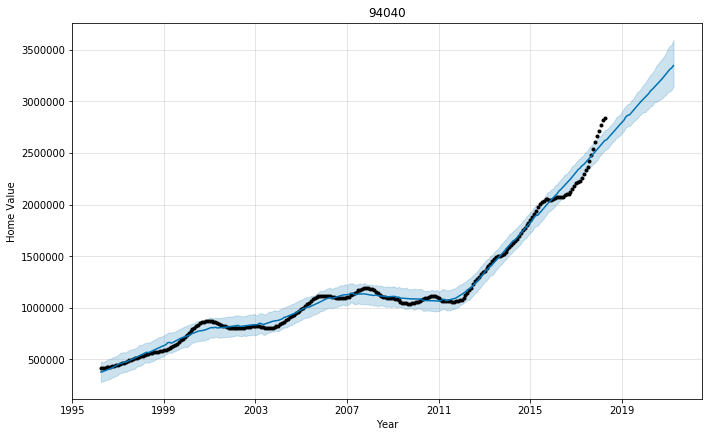

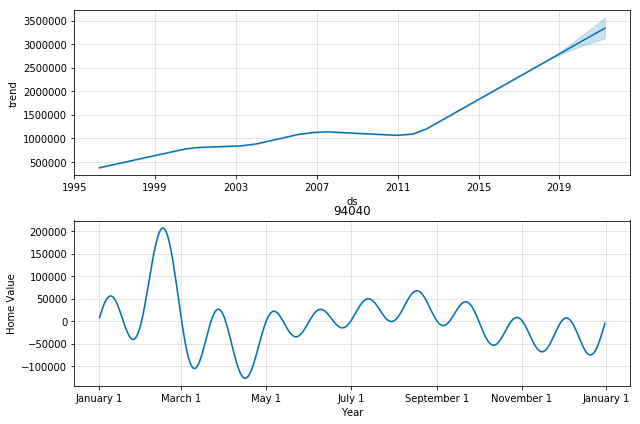

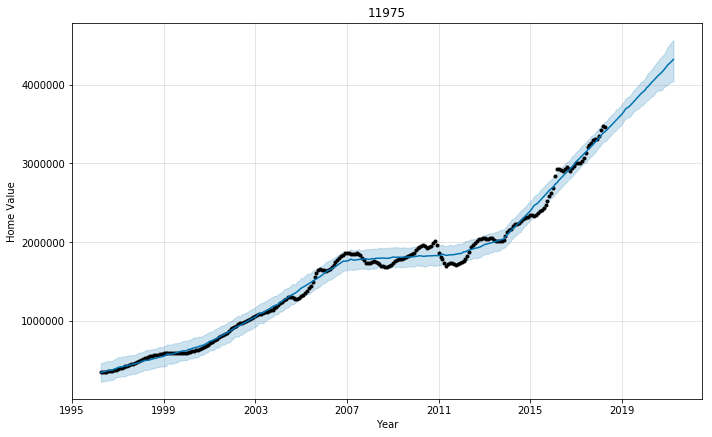

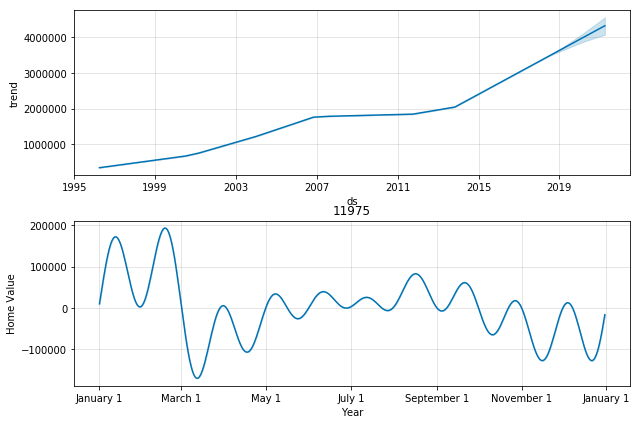

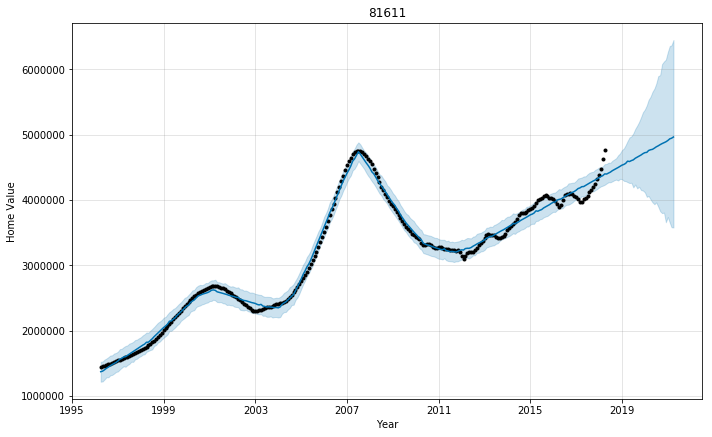

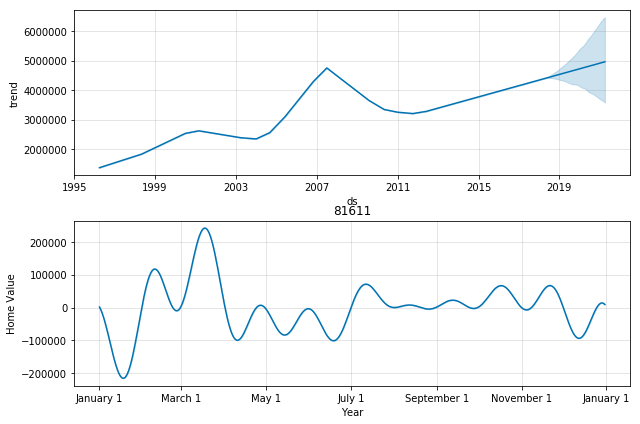

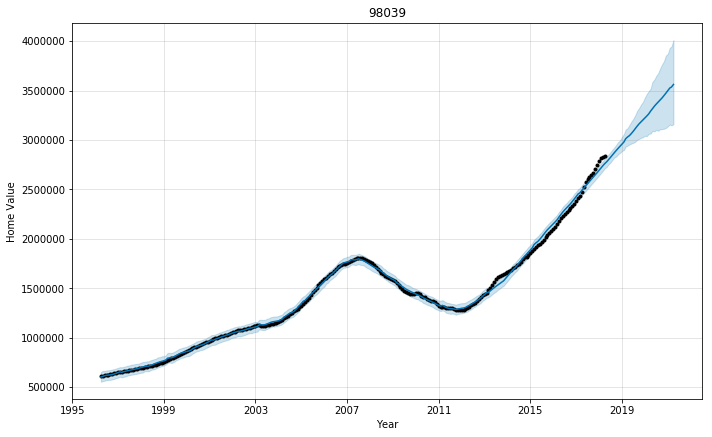

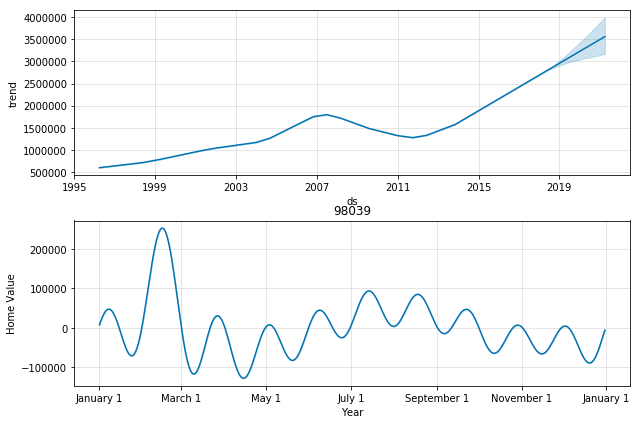

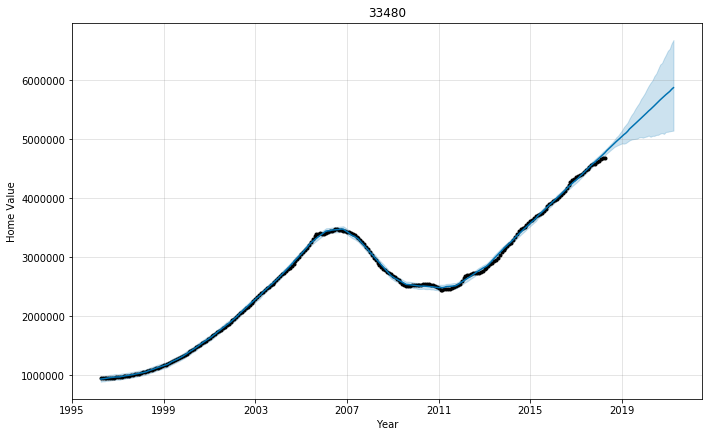

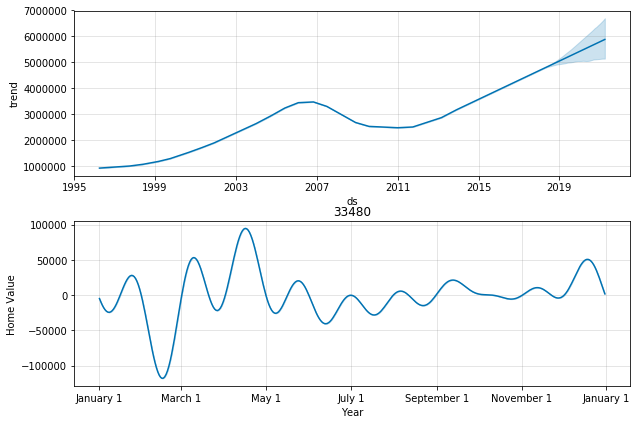

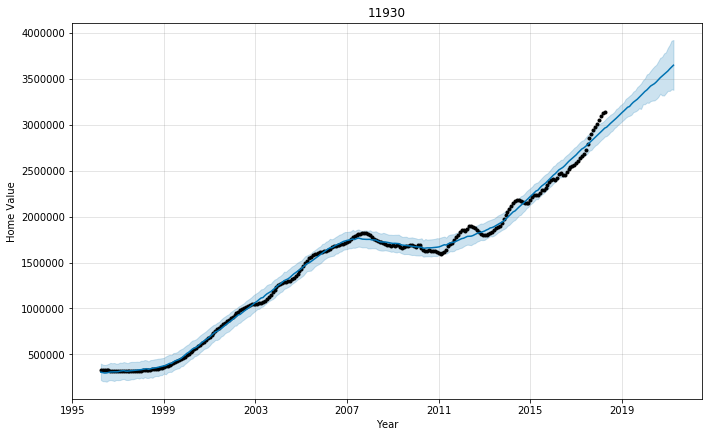

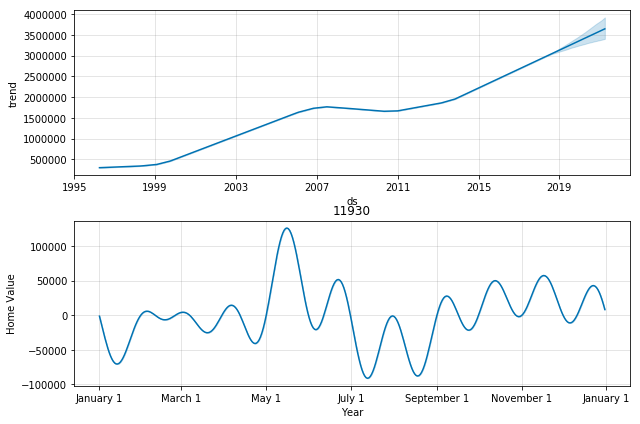

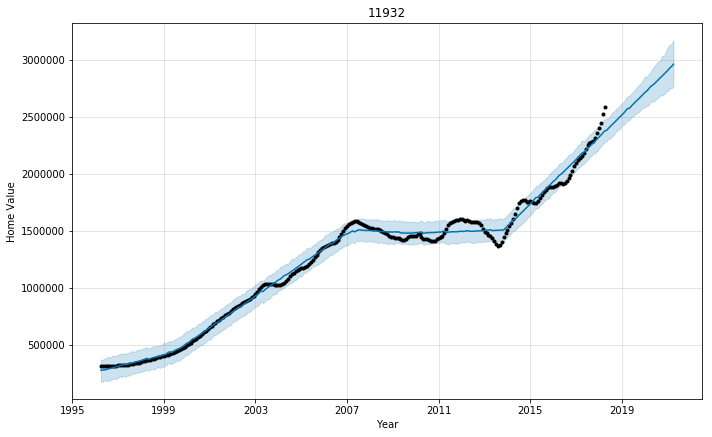

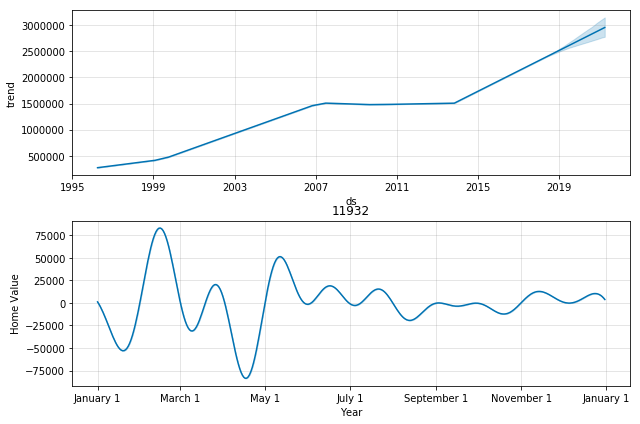

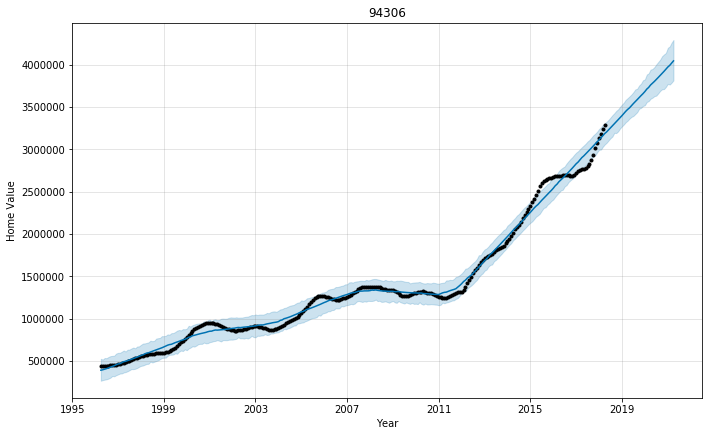

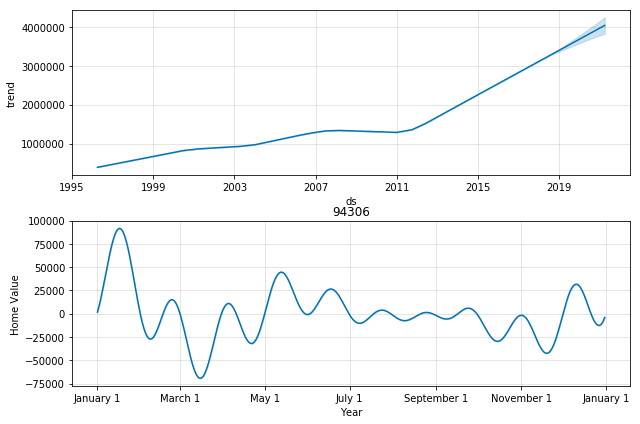

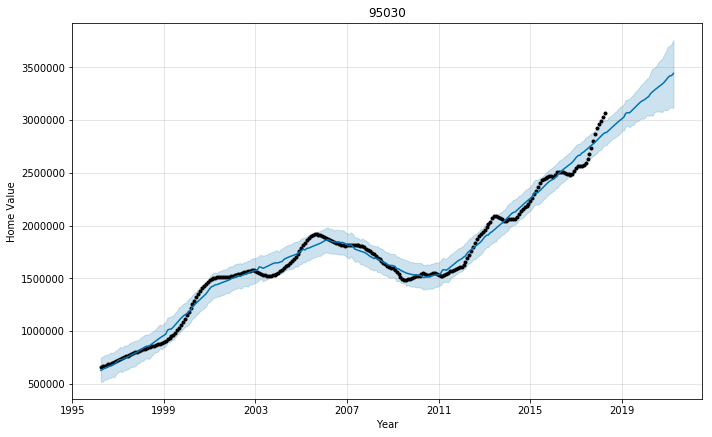

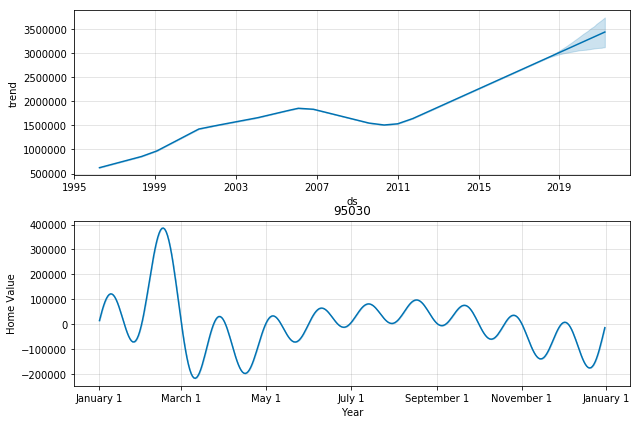

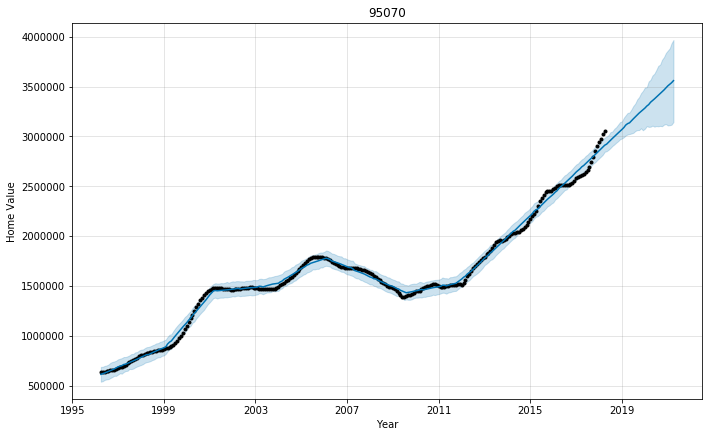

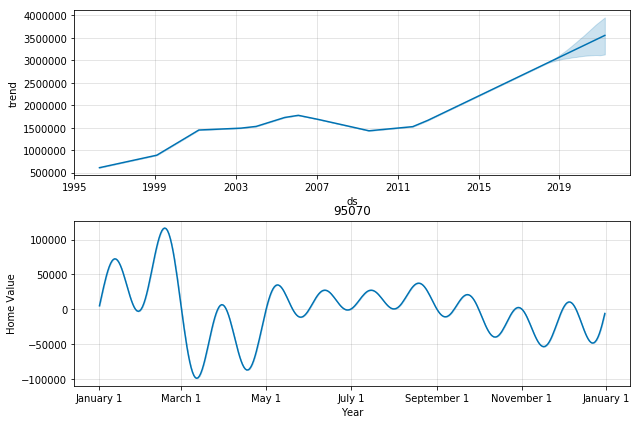

In [26]:
vals = prophet_prediction(dfx, top15)

# Running model and plotting visualizing each zip-code's model's result.

In [20]:
vals

# The predicted values when we only use data since the trough of 2012 are significantly higher than the the predicted 
# values below that take into account all the data provided. I am a proponent of conservative predictions as it is 
# much better to overdeliver.

[(94027, 2707113.1),
 (90210, 2160768.42),
 (94301, 1330665.06),
 (94022, 1384253.88),
 (94024, 1095845.02),
 (94040, 637365.77),
 (11975, 1142104.71),
 (81611, 1710540.68),
 (98039, 836209.54),
 (33480, 2308861.29),
 (11930, 1203905.65),
 (11932, 983616.67),
 (94306, 732215.47),
 (95030, 1167171.92),
 (95070, 1114737.83)]

In [ ]:
# The top 5 zip-codes in order are 94027, 33480, 90210, 81611, 94022